## 5. Spatial climate analysis

In this example we'll be using a historical rainfall dataset to look at past trends in precipitation over Australia. The dataset is nine years of monthly precipitation measurements in mm/month from 1961 to 1970. A snapshot of the data for Feb 1962 and the Australia state boundaries are shown below:

![image](https://gitlab.com/geostack/library/-/wikis/uploads/a336f2ab23f12811b552cd38bca42334/image.png)

### Quartiles

To find quartiles of this dataset, we can read and sort the data as in the earlier example. The code below reads, sorts then shows the median monthly precipitation:

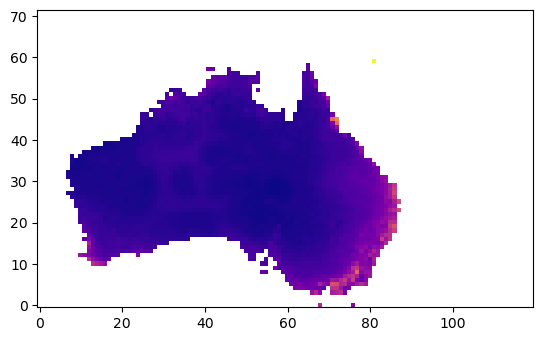

In [1]:
from geostack.raster import Raster, sortColumns

# Read monthly precipitation file
prec = Raster(name = 'prec')
prec.read('./data/03_example.nc')

# Sort
sortColumns(prec, inplace = True)

# Plot median
import matplotlib.pyplot as plt
plt.imshow(prec.data[int(prec.getDimensions().nz/2)], interpolation='none', cmap='plasma', origin='lower');

# Write median
#prec.write('prec_median.tif', { 'layers': prec.getDimensions().nz/2})

### Aggregation over states

For a more complex example we'd like to aggregate this into years, then work out the maximum yearly rainfall per Australian state. Here, for demonstration, we use a _RasterFile_ object to read the data from the NetCDF file. This is a much more versatile reader backed by GDAL, NetCDF and XArray and can handle any data format supported by these libraries. The library for performing the data read is specified using the _backend_ parameter, here _netcdf_:

In [2]:
from geostack.raster import RasterFile
from geostack.core import ProjectionParameters

# Read monthly precipitation file
prec = RasterFile(filePath = './data/03_example.nc', name = 'prec', backend = 'netcdf')
prec.setProjectionParameters(ProjectionParameters.from_proj4('+proj=longlat +datum=WGS84 +no_defs +type=crs'))
prec.read(layers = -1)

NetCDF files can contain multiple variables, the data variable can be specified if required otherwise it defaults to using a variable with the same name as the Raster, here _prec_. It should be noted that the file path needs to be specified when creating the RasterFile, rather than in _read_. Once created the projection is manually set as the NetCDF file contains no projection information. Then the data is read using the _read_ function. The _layers_ parameters is given in index notation, if this is omitted only the first layer is read. The RasterFile handler inpects the data and aligns so spatial dimensions are on the x and y axes and time, if it exists, is on the z direction. The -1 here instructs the RasterFile to read all layers from the data.

The next step is to build a Raster to hold the yearly aggregation. Similar to the example in an earlier section this is created manually from the dimensions of the _prec_ Raster. However, as the _prec_ data is monthly the number of layers is divided by twelve:

In [3]:
# Create Raster to hold yearly data
year_sum = Raster(name = "year_sum")
dims = prec.getDimensions()
year_sum.init(
    nx = dims.nx, ny = dims.ny, nz = dims.nz/12,
    hx = dims.hx, hy = dims.hy, hz = 1.0,
    ox = dims.ox, oy = dims.oy, oz = 0.0
)
year_sum.setProjectionParameters(prec.getProjectionParameters())

Then to calculate the yearly precipitation:

In [4]:
from geostack.runner import runScript

# Sum monthly data
runScript('''
        year_sum = 0.0;
        for (int k = 0; k < 12; k++) {
            year_sum += prec[kpos*12+k];
        }
    ''', [year_sum, prec]);

The script is run over the _year_sum_ Raster so we can loop and sum over twelve values of the aligned _prec_ dataset. The _kpos_ term is a special value holding the current layer for the cell being calculated (similarly there are _ipos_ and _jpos_ values if required). 

Next the Australian state polyon file is loaded:

In [6]:
from geostack.vector import Vector

aus = Vector.from_geojson('./data/05_example.geojson')
aus.addProperty('annual_prec');

A _runVectorScript_ operation with _ReductionType.Maximum_ to find the maximum cells within each polygon:

In [7]:
from geostack.runner import runVectorScript
from geostack.definitions import ReductionType, VectorLayerHandling

# Compute state-based yearly rainfall
runVectorScript("annual_prec = year_sum;", aus, [year_sum], 
    ReductionType.Maximum, VectorLayerHandling.ByLayer);

After this step the values are stored as year arrays for each polygon, for example for polygon 0:

In [8]:
print(aus.getProperty(0, "annual_prec"))

[1935.0038 2536.75   2653.54   1692.9819 1518.0566 1685.0535 2138.5576
 1480.5076 1707.3529]


However, the polygon dataset is made up of possibly disconnected polygons such as islands meaning several polygons are part of one state. One further Python-based step is needed to get a per-state maximum. The data is aggregated into a dictionary based on state code, where the element-wise maximum of the arrays are calculated:

In [9]:
import numpy as np

# Aggregate data
data = {}
for idx in aus.getPolygonIndexes():

    # Get data
    code = aus.getProperty(idx, "code", str)
    value = np.nan_to_num(aus.getProperty(idx, "annual_prec", float))
        
    # Update dictionary
    if code in data:
        data[code] = np.maximum(data[code], value)
    else:
        data[code] = value

print(data['VIC'])

[1484.6714  1477.3397  1475.1664  1658.1097  1315.1842  1691.9203
  912.60156 1646.6708  1410.3903 ]
